In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import re
import unicodedata
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_json('data/raw/readme_data200.json')

In [4]:
import src.prepare as prepare

In [5]:
df = prepare.clean_language(df)

In [6]:
#javascript(0-48), python(49-98), java(99-148), c++(149-198)

In [7]:
train = df.iloc[0:30]

In [8]:
train = train.append(df.iloc[49: 79])

In [10]:
train = train.append(df.iloc[99: 129])

In [12]:
train = train.append(df.iloc[149: 179])

In [13]:
train.language.value_counts()

C++           30
Python        30
Java          30
JavaScript    30
Name: language, dtype: int64

In [15]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']


def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower().strip())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [20]:
js_words = clean(''.join(train[train.language == 'JavaScript'].readme))
python_words = clean(''.join(train[train.language == 'Python'].readme))
java_words = clean(''.join(train[train.language == 'Java'].readme))
c_words = clean(''.join(train[train.language == 'C++'].readme))
all_words = clean(''.join(train.readme))

In [22]:
js_freq = pd.Series(js_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [23]:
word_counts = (pd.concat([all_freq, js_freq, python_freq, java_freq, c_freq ], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'c++'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(20)

,all,javascript,python,java,c++
0,70,3,44,21,2
00985589,2,0,2,0,0
01,2,1,0,0,1
011,1,1,0,0,0
011122100,1,1,0,0,0
012,1,1,0,0,0
0120,1,0,0,1,0
01exceptionclass,1,0,0,0,1
02,2,0,0,0,2
020,1,1,0,0,0


In [28]:
word_counts.sort_values(by='all', ascending=False).head(20)


,all,javascript,python,java,c++
data,397,62,237,70,28
file,261,50,81,100,30
r,247,0,247,0,0
project,223,26,87,79,31
run,183,59,61,28,35
install,183,70,58,24,31
use,182,55,58,38,31
using,175,26,85,34,30
new,170,31,69,55,15
code,154,35,48,43,28


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of business vs sports vs tech vs entertainment for the 20 most common words')

<Figure size 864x864 with 0 Axes>

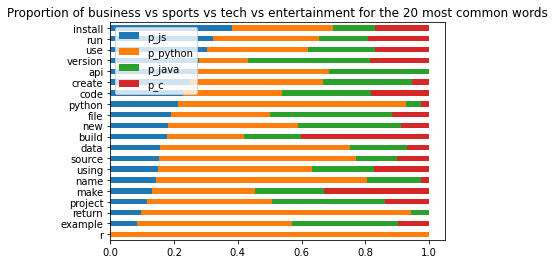

In [27]:
plt.figure(figsize=(12,12))
(word_counts
 .assign(p_js=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_c=word_counts['c++'] / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python', 'p_java', 'p_c']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))
plt.title('Proportion of business vs sports vs tech vs entertainment for the 20 most common words')

In [31]:
from wordcloud import WordCloud


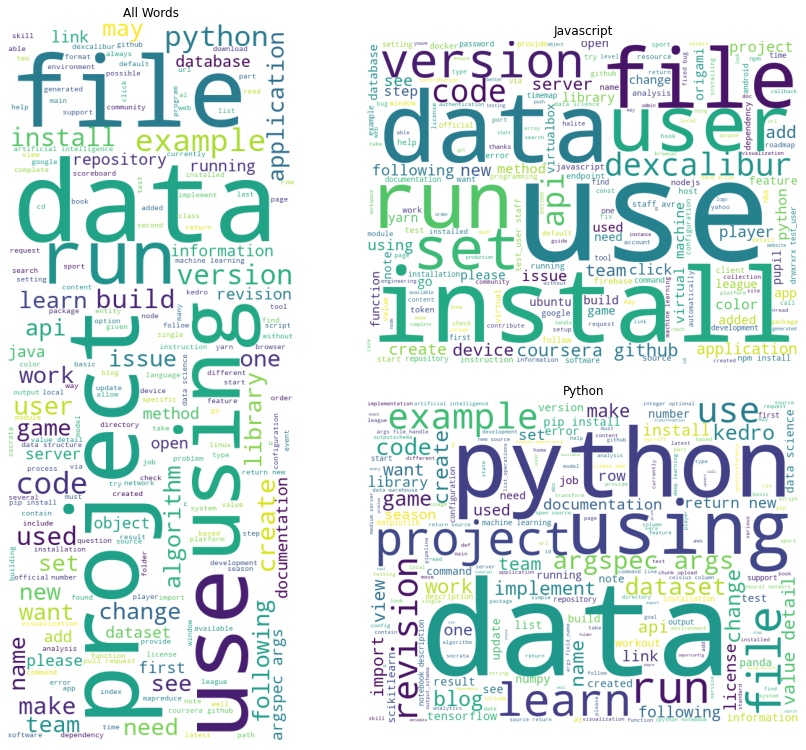

In [38]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words))
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(c_words))



plt.figure(figsize=(12, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(js_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Javascript')
axs[2].set_title('Python')

for ax in axs: ax.axis('off')

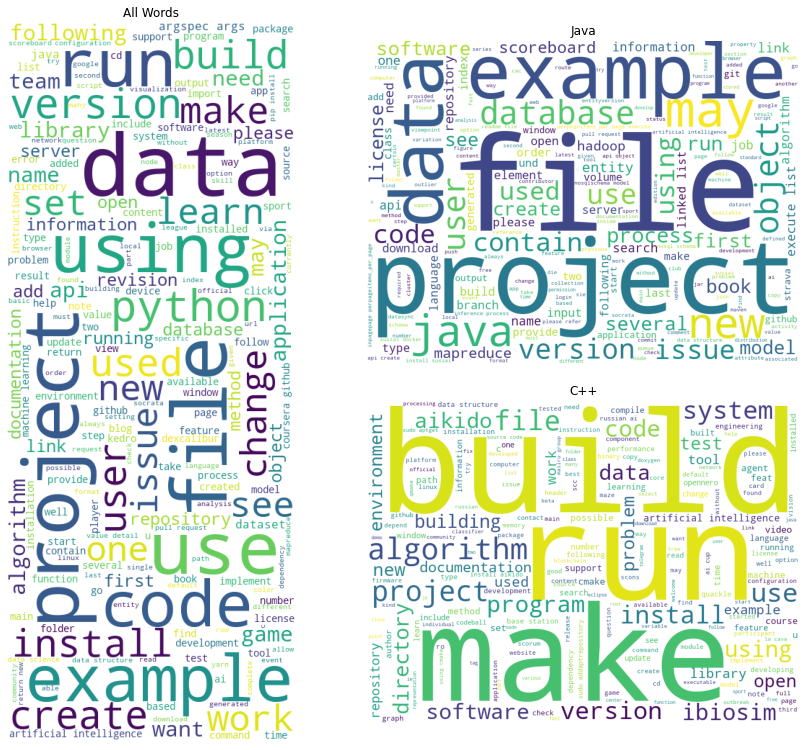

In [45]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words))
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(c_words))



plt.figure(figsize=(12, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(c_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Java')
axs[2].set_title('C++')

for ax in axs: ax.axis('off')

# Bi-Grams

In [46]:
#Javascript
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts(ascending=False)
                      .head(20))

top_20_js_bigrams.head()

(coursera, github)    33
(virtual, machine)    23
(npm, install)        18
(test_user, staff)    17
(29, avr)             17
dtype: int64

In [40]:
#Python
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(argspec, args)    56
(value, 0)         31
(return, new)      24
(pip, install)     23
(data, science)    21
dtype: int64

In [41]:
#Java
top_20_java_bigrams = (pd.Series(nltk.ngrams(java_words, 2))
                      .value_counts()
                      .head(20))

top_20_java_bigrams.head()

(execute, list)                        20
(linked, list)                         18
(artificial, intelligence)             16
(inpagepage, perpageitems_per_page)    14
(perpageitems_per_page, execute)       14
dtype: int64

In [42]:
#C++
top_20_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

top_20_c_bigrams.head()

(artificial, intelligence)    14
(data, structure)              9
(base, station)                9
(sudo, addaptrepository)       8
(ai, cup)                      8
dtype: int64

# Visualize

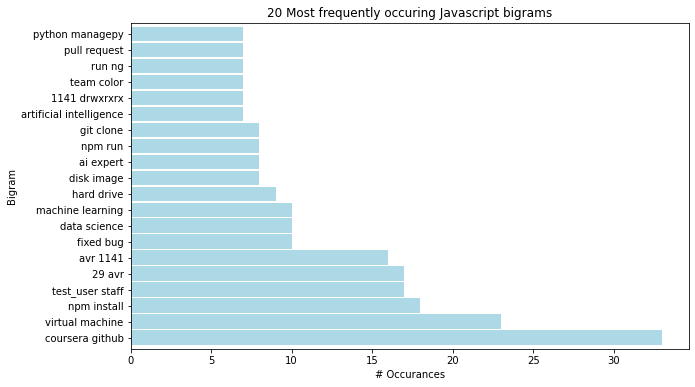

In [47]:
top_20_js_bigrams.plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Javascript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

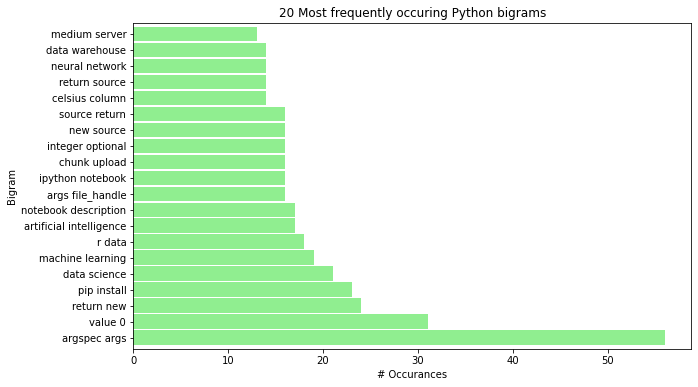

In [51]:
top_20_python_bigrams.plot.barh(color='lightgreen', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

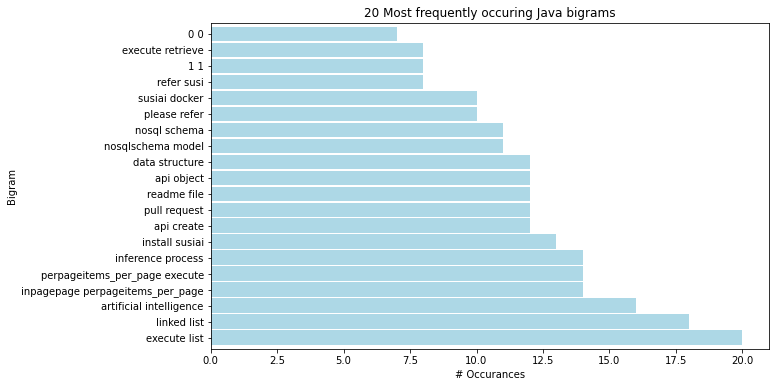

In [54]:
top_20_java_bigrams.plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Java bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_java_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

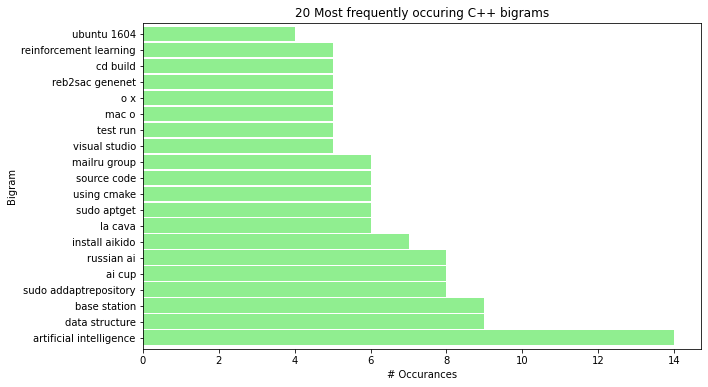

In [55]:
top_20_c_bigrams.plot.barh(color='lightgreen', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C++ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')


ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

# Bi-gram Word Cloud

(-0.5, 799.5, 399.5, -0.5)

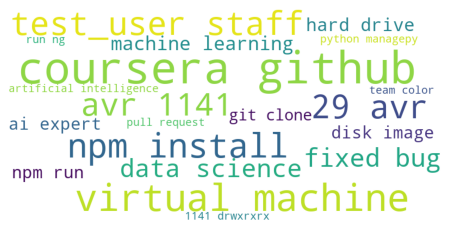

In [56]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

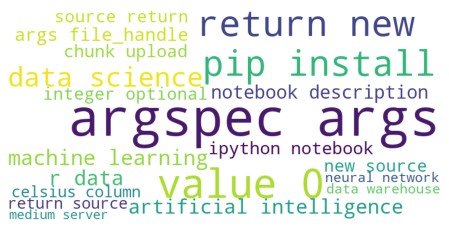

In [57]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

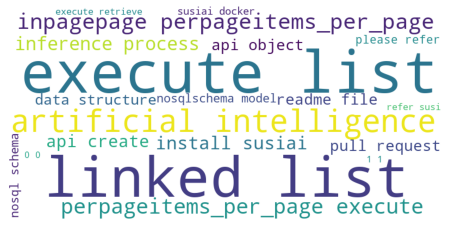

In [58]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

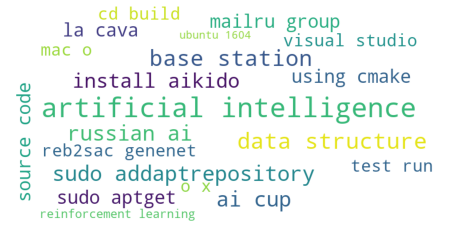

In [59]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_c_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# Tri-grams

In [60]:
#Javascript
top_20_js_trigrams = (pd.Series(nltk.ngrams(js_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_js_trigrams.head()

(29, avr, 1141)               16
(avr, 1141, drwxrxrx)          7
(python, coursera, github)     5
(7, test_user, staff)          5
(aptget, update, sudo)         5
dtype: int64

In [62]:
#Javascript
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_python_trigrams.head()

(return, new, source)                 15
(source, return, new)                 14
(return, source, return)              14
(ipython, notebook, demonstrating)    11
(new, source, example)                10
dtype: int64

In [63]:
#Javascript
top_20_java_trigrams = (pd.Series(nltk.ngrams(java_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_java_trigrams.head()

(inpagepage, perpageitems_per_page, execute)    14
(install, susiai, docker)                       10
(perpageitems_per_page, execute, list)           9
(please, refer, susi)                            8
(artificial, intelligence, human)                7
dtype: int64

In [64]:
#Javascript
top_20_java_trigrams = (pd.Series(nltk.ngrams(java_words, 3))
                      .value_counts(ascending=False)
                      .head(20))

top_20_java_trigrams.head()

(inpagepage, perpageitems_per_page, execute)    14
(install, susiai, docker)                       10
(perpageitems_per_page, execute, list)           9
(please, refer, susi)                            8
(artificial, intelligence, human)                7
dtype: int64